In [1]:
%pip install slangtorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
import slangtorch
import random

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [4]:
def grid_size(shape, threads_dim = 16):
    return ((shape[0] + threads_dim - 1)//threads_dim, (shape[1] + threads_dim - 1)//threads_dim, 1)


In [5]:
import json

with open('scene_sample.json', 'r') as f:
    data = f.read()
    cfg = json.loads(data)

# cfg['cameras'][0]['pos']=[0, 2, 10]
# cfg['cameras'][0]['look_at']=[0, 1, 0]

In [6]:
block_size = (16, 16, 1)
shap = (cfg['render_width'], cfg['render_height'])
grid_size2 = grid_size(shap)

In [7]:
for obj in cfg['geometry']:
  print(obj)

{'type': 'plane', 'point': [0.0, -2.0, 0.0], 'normal': [0.0, 1.0, 0.0], 'material_id': 0}
{'type': 'sphere', 'center_radius': [0.0, 1.5, 0.0, 2.0], 'material_id': 2}
{'type': 'sphere', 'center_radius': [1.0, -1.0, 1.0, 1.0], 'material_id': 1}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, 1.0, 1.0], 'material_id': 3}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, -1.0, 1.0], 'material_id': 4}
{'type': 'sphere', 'center_radius': [-1.0, -1.0, -1.0, 1.0], 'material_id': 5}
{'type': 'sphere', 'center_radius': [5.0, 4.0, -1.0, 2.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-5.0, 4.0, -1.0, 2.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [3.0, 2.0, 4.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-3.0, 2.0, 4.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [3.0, 2.0, -2.0, 1.0], 'material_id': 6}
{'type': 'sphere', 'center_radius': [-3.0, 2.0, -2.0, 1.0], 'material_id': 6}


In [53]:
def prepare_materials(json_config):
    """Подготовка массива материалов из JSON конфигурации"""
    materials = json_config.get("materials", [])

    # Если материалов нет, создаем один дефолтный
    if not materials:
        # Структура: [тип(0=diffuse, 1=mirror, 2=glass), color(r,g,b), texture_id(-1=нет)]
        materials_array = np.zeros((1, 7), dtype=np.float32)
        materials_array[0, 0] = 0  # тип: diffuse
        materials_array[0, 1:4] = [0.8, 0.8, 0.8]  # серый цвет
        materials_array[0, 4] = -1  # нет текстуры
        materials_array[0, 5:7] = [0, 0]  # дополнительные параметры
        return torch.tensor(materials_array, dtype=torch.float32).cuda(), 1

    # Находим максимальный ID материала и создаем соответствующий массив
    max_id = max(mat.get("id", i) for i, mat in enumerate(materials))
    materials_array = np.zeros((max_id + 1, 7), dtype=np.float32)

    # По умолчанию все материалы диффузные серые
    materials_array[:, 0] = 0  # тип: diffuse
    materials_array[:, 1:4] = [0.8, 0.8, 0.8]  # серый цвет
    materials_array[:, 4] = -1  # нет текстуры

    # Заполняем массив материалов
    for mat in materials:
        mat_id = mat.get("id", 0)
        mat_type = mat.get("type", "diffuse")

        # Записываем тип материала
        if mat_type == "diffuse":
            materials_array[mat_id, 0] = 0
        elif mat_type == "mirror":
            materials_array[mat_id, 0] = 1
        elif mat_type == "glass":
            materials_array[mat_id, 0] = 2
        # можно добавить другие типы материалов

        # Цвет материала (по умолчанию белый)
        color = mat.get("color", [1.0, 1.0, 1.0])
        materials_array[mat_id, 1:4] = color[:3]

        # Текстура (если есть)
        if "texture" in mat:
            # Здесь нужно сопоставить текстуру с ID в текстурном буфере
            # Пока просто отмечаем, что текстура есть (будет реализовано позже)
            materials_array[mat_id, 4] = 1.0
        else:
            materials_array[mat_id, 4] = -1.0

        # Дополнительные параметры для материалов разных типов
        # Например, для стекла это может быть индекс преломления
        if mat_type == "glass" and "refraction_index" in mat:
            materials_array[mat_id, 5] = mat["refraction_index"]

    return torch.tensor(materials_array, dtype=torch.float32).cuda(), max_id + 1

def prepare_scene_objects(json_config):
    geometry = json_config["geometry"]
    num_objects = len(geometry)

    # Загрузка всех текстур
    textures = []
    texture_offsets = []
    current_offset = 0

    # Создаем соответствие между путем к текстуре и её индексом в буфере
    texture_paths_to_indices = {}

    # структура: [type, data0(x,y,z,w), data1(x,y,z,w), material_id,
    #             has_texture, texture_offset, texture_width, texture_height]
    sdf_array = np.zeros((num_objects, 14), dtype=np.float32)

    for i, obj in enumerate(geometry):
        if obj["type"] == "sphere":
            sdf_array[i, 0] = 1  # type: sphere
            sdf_array[i, 1:5] = obj["center_radius"]
            sdf_array[i, 9] = obj["material_id"]
        elif obj["type"] == "plane":
            sdf_array[i, 0] = 0  # type: plane
            sdf_array[i, 1:4] = obj["point"]
            sdf_array[i, 5:8] = obj["normal"]
            sdf_array[i, 9] = obj["material_id"]
        else:
            raise ValueError(f"Unknown geometry type: {obj['type']}")

        # Обработка текстур для материалов
        material_id = int(sdf_array[i, 9])
        has_texture = False

        # Проверяем, есть ли у материала текстура
        for mat in json_config.get("materials", []):
            if mat.get("id") == material_id and "texture" in mat:
                has_texture = True
                texture_path = mat["texture"]

                # Если эта текстура уже загружена, используем её индекс
                if texture_path in texture_paths_to_indices:
                    texture_info = texture_paths_to_indices[texture_path]
                    sdf_array[i, 10] = 1.0  # has_texture = true
                    sdf_array[i, 11] = texture_info[0]  # offset
                    sdf_array[i, 12] = texture_info[1]  # width
                    sdf_array[i, 13] = texture_info[2]  # height
                else:
                    # Загружаем новую текстуру
                    texture, width, height = load_texture(texture_path)
                    textures.append(texture)

                    # Сохраняем информацию о текстуре
                    sdf_array[i, 10] = 1.0  # has_texture = true
                    sdf_array[i, 11] = current_offset
                    sdf_array[i, 12] = width
                    sdf_array[i, 13] = height

                    # Запоминаем смещение для следующей текстуры
                    texture_offsets.append((current_offset, width, height))
                    texture_paths_to_indices[texture_path] = (current_offset, width, height)
                    current_offset += width * height

                break

        if not has_texture:
            sdf_array[i, 10] = 0.0  # has_texture = false
            sdf_array[i, 11:14] = 0  # нет текстуры

    # Создаем тензор объектов
    sdf_tensor = torch.tensor(sdf_array, dtype=torch.float32).cuda()

    # Создаем общий буфер текстур
    if textures:
        # Объединяем все текстуры в один буфер
        # Форматируем как [offset, r, g, b]
        total_pixels = current_offset
        texture_buffer = torch.zeros((total_pixels, 3), dtype=torch.float32).cuda()

        current_pos = 0
        for tex_idx, texture in enumerate(textures):
            offset, width, height = texture_offsets[tex_idx]
            tex_flat = texture.view(-1, 3)  # сплющиваем в одномерный массив пикселей
            pixel_count = tex_flat.shape[0]

            texture_buffer[offset:offset+pixel_count] = tex_flat
    else:
        # Если текстур нет, создаем минимальный буфер
        texture_buffer = torch.zeros((1, 3), dtype=torch.float32).cuda()

    return sdf_tensor, num_objects, texture_buffer

def prepare_camera_struct(config):
    cam = config["cameras"][0]
    pos = cam["pos"]
    look_at = cam["look_at"]
    up = cam["up"]
    vfov = cam.get("vfov", 60)
    params = (*pos, *look_at, *up, vfov)
    return params

def load_texture(texture_path, default_size=(256, 256)):
    """Загружает текстуру из файла или создает простую текстуру по умолчанию"""
    if not texture_path or not os.path.exists(texture_path):
        print(f"Warning: Texture {texture_path} not found. Using default texture.")
        # Создаем простую шахматную текстуру
        width, height = default_size
        img = np.zeros((height, width, 3), dtype=np.float32)
        cell_size = 32
        for y in range(height):
            for x in range(width):
                cell_x = x // cell_size
                cell_y = y // cell_size
                if (cell_x + cell_y) % 2 == 0:
                    img[y, x] = [0.9, 0.9, 0.9]  # белый
                else:
                    img[y, x] = [0.1, 0.1, 0.1]  # черный
    else:
        # Загружаем изображение
        print(f"Loading texture: {texture_path}")
        img = np.array(Image.open(texture_path).convert("RGB")).astype(np.float32) / 255.0

    # Преобразуем в тензор PyTorch и передаем на GPU
    texture_tensor = torch.tensor(img, dtype=torch.float32).cuda()
    return texture_tensor, img.shape[1], img.shape[0]  # возвращаем тензор и размеры (width, height)

In [52]:
def load_environment_texture(texture_path):
    """Загрузить и подготовить текстуру окружения как TensorView"""
    if not os.path.exists(texture_path):
        print(f"Warning: Environment texture {texture_path} not found. Using default texture.")
        # Создаем простую градиентную текстуру
        print("fuck")
        width, height = 512, 512
        img = np.zeros((height, width, 3), dtype=np.float32)
        for y in range(height):
            for x in range(width):
                img[y, x, 0] = x / width  # R
                img[y, x, 1] = y / height  # G
                img[y, x, 2] = 0.5  # B
    else:
        # Загружаем изображение
        print(f"Loading environment texture: {texture_path}")
        img = np.array(Image.open(texture_path)).astype(np.float32) / 255.0

    # Преобразуем в тензор PyTorch и передаем на GPU
    env_tensor = torch.tensor(img, dtype=torch.float32).cuda()
    return env_tensor

In [45]:
import os
from PIL import Image

# Загрузить текстуру environment lighting
env_texture_path = "balls.png"
for light in cfg.get("lights", []):
    if light.get("type") == "environment":
        env_texture_path = light.get("texture")
        break

env_texture = load_environment_texture(env_texture_path)

Loading environment texture: balls.png


In [46]:
# prepare_scene_objects(cfg)

In [59]:
m = slangtorch.loadModule("render.slang")

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [60]:
materials_tensor, materials_count = prepare_materials(cfg)

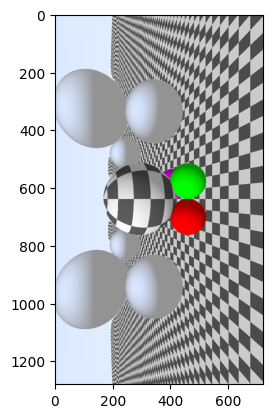

In [61]:
scene_tensor, obj_count, texture_buffer = prepare_scene_objects(cfg)

output = torch.zeros((cfg["render_width"], cfg["render_height"], 3), dtype=torch.float32).cuda()

m.render(
    output=output,
    objects=scene_tensor,
    obj_count=obj_count,
    inp_camera_params=prepare_camera_struct(cfg),
    textures=texture_buffer,
    materials=materials_tensor,
    materials_count=materials_count
    # env_texture=env_texture
).launchRaw(blockSize=block_size, gridSize=grid_size2)

plt.imshow(output.cpu())

In [ ]:
print("pos", cfg["cameras"][0]["pos"])
print("look_at", cfg["cameras"][0]["look_at"])

pos [0, 4, 10]
look_at [0, 0, -1]
